# Cerebral Stroke Prediction using Imbalance dataset

#### =======  Let's adjust sampling parameters and see the results  =======

## Introduction

A stroke, also known as a cerebrovascular accident or CVA is when part of the brain loses its blood supply and the part of the body that the blood-deprived brain cells control stops working. This loss of blood supply can be ischemic because of lack of blood flow, or hemorrhagic because of bleeding into brain tissue. A stroke is a medical emergency because strokes can lead to death or permanent disability. There are opportunities to treat ischemic strokes but that treatment needs to be started in the first few hours after the signs of a stroke begin.

Content:

The cerebral Stroke dataset consists of 12 features including the target column which is imbalanced.

Since the dataset is severely imbalance; we will settle for a conservative strategy of having non-stroke classification accuracy for about 85%

## Loading data and libs

In [338]:
import warnings
warnings.filterwarnings('ignore')


In [339]:
### Install any package or module that is not installed
# Imblearn has been installed earlier
# using " !pip install [module name]"

In [340]:
import numpy
print(numpy.__version__)

1.19.0


In [1]:
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [2]:
pd.set_option('display.max_columns', 60)

In [3]:
data = pd.read_csv('cerebralStroke.csv')
data.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0
5,32257,Female,47.0,0,0,Yes,Private,Urban,210.95,50.1,NaN,0
6,52800,Female,52.0,0,0,Yes,Private,Urban,77.59,17.7,formerly smoked,0
7,41413,Female,75.0,0,1,Yes,Self-employed,Rural,243.53,27.0,never smoked,0
8,15266,Female,32.0,0,0,Yes,Private,Rural,77.67,32.3,smokes,0
9,28674,Female,74.0,1,0,Yes,Self-employed,Urban,205.84,54.6,never smoked,0


In [4]:
data.shape

(43400, 12)

In [5]:
data.info() #This will not print with numpy version 1.20.0 ; it only works with lesser but eli5 work with this higer version

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 43400 non-null  int64  
 1   gender             43400 non-null  object 
 2   age                43400 non-null  float64
 3   hypertension       43400 non-null  int64  
 4   heart_disease      43400 non-null  int64  
 5   ever_married       43400 non-null  object 
 6   work_type          43400 non-null  object 
 7   Residence_type     43400 non-null  object 
 8   avg_glucose_level  43400 non-null  float64
 9   bmi                41938 non-null  float64
 10  smoking_status     30108 non-null  object 
 11  stroke             43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


In [6]:
'Dataset contains nulls ?: {}'.format(data.isnull().any().any())

'Dataset contains nulls ?: True'

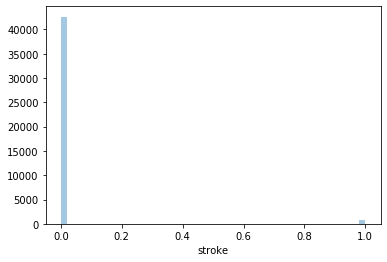

In [8]:
sns.distplot(a=data.stroke, kde=False)

In [9]:
per = ((data['stroke'][data.stroke==0].count())/data.stroke.count())*100
print('The percentage of non-stroke data is : {}%'.format(round(per, 2)))

The percentage of non-stroke data is : 98.2%


In [10]:
# dropping NAN

data.dropna(inplace=True)

'Dataset contains nulls ?: {}'.format(data.isnull().any().any())

'Dataset contains nulls ?: False'

#### Data preprocessing

In [11]:
data = data.drop(labels='id', axis=1)

In [12]:
# Replacing values in gender column; Male=1, Female=2 and others=3
data["gender"].replace({'Male':1, 'Female':2, 'Other':3}, inplace=True)

# Replacing values in ever_married column; Yes=1, No=0
data["ever_married"].replace({'Yes':1, 'No':0}, inplace=True)

# Replacing values in work_type 
data["work_type"].replace({'children':1, 'Self-employed':2, 'Private':3, 'Never_worked':4, 'Govt_job':5}, inplace=True)

# Replacing values in Residence_type 
data["Residence_type"].replace({'Rural':1, 'Urban':2}, inplace=True)

# Replacing values in smoking_status column
data["smoking_status"].replace({'never smoked':0, 'smokes':1, 'formerly smoked':2}, inplace=True)

In [13]:
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,1,58.0,1,0,1,3,2,87.96,39.2,0,0
3,2,70.0,0,0,1,3,1,69.04,35.9,2,0
6,2,52.0,0,0,1,3,2,77.59,17.7,2,0
7,2,75.0,0,1,1,2,1,243.53,27.0,0,0
8,2,32.0,0,0,1,3,1,77.67,32.3,1,0


In [14]:
# Initial target classes count
data.groupby("stroke").count()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
stroke,,,,,,,,,,
0,28524,28524,28524,28524,28524,28524,28524,28524,28524,28524
1,548,548,548,548,548,548,548,548,548,548


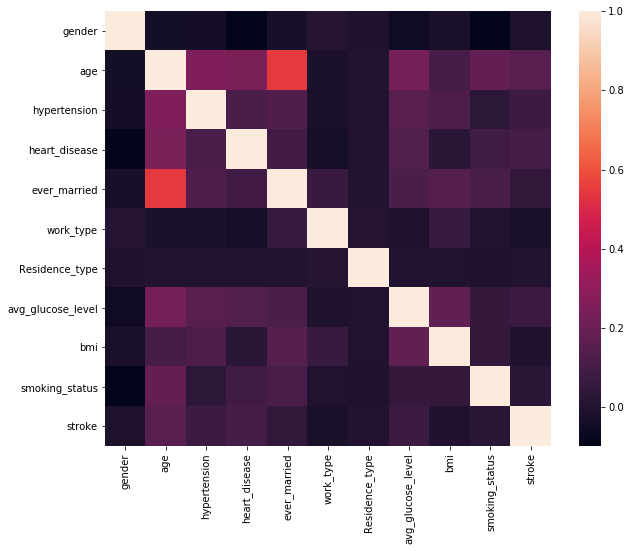

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(data=data.corr())

In [16]:
# Create correlation matrix
corr_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop features 
data.drop(to_drop, axis=1, inplace=True)

In [17]:
data.shape

(29072, 11)

#### Lets adopt exact the codes for African Recession prediction

## Model training
First, we need to develop a method to correctly measure model accuracy. Since our target variable has a class imbalance, we need something a little bit more complex than simple cross-validation. We'll use the following scheme:

- Randomly split data on train and test sets.
- Handle class imbalance in train set with one of three available methods: random undersampling, random oversampling or oversampling with SMOTE algorithm.
- Train and test the model, separately measuring the accuracy of determining a recession and accuracy of determining the absence of a recession.
- Repeat this multiple times and average the results.

##### Parameter adjusting for under sampler:
The under sampled data should not be exactly equal, to avoid overfitting the aim is to under sample the majority class to 50 and 60 percent more than the minority class, depending on how we combine them (hence the sampling_strategy=0.5 or 0.6; in the undersampling code below)

##### Parameter adjusting for over sampler:
The over sampled data should not be exactly equal, to avoid overfitting the aim is to over sample the minority class to 50 or 60 percent of the majority class depending on how we combine them (hence the sampling_strategy=0.5 or 0.6; in the oversampling code below)

#### Main Functions

In [18]:
def test_with_tts(model, data, smpl_strat='rusamp', random_state=0):
    
    X_train, X_test, y_train, y_test = train_test_split(
        data.drop('stroke', axis=1), 
        data.stroke, 
        random_state=random_state
    )
    if smpl_strat == 'rusamp':
        rus = RandomUnderSampler(sampling_strategy=0.5,random_state=0)
        X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
    elif smpl_strat == 'rosamp':
        ros = RandomOverSampler(sampling_strategy=0.5,random_state=0)
        X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    elif smpl_strat == 'smote':
        smote = SMOTE(sampling_strategy=0.5,random_state=0)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    elif smpl_strat == 'roruSamp':
        ros = RandomOverSampler(sampling_strategy=0.5,random_state=0)
        rus = RandomUnderSampler(sampling_strategy=0.6,random_state=0)
        X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
        X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)
    elif smpl_strat == 'ruroSamp':
        ros = RandomOverSampler(sampling_strategy=0.6,random_state=0)
        rus = RandomUnderSampler(sampling_strategy=0.5,random_state=0)
        X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
        X_resampled, y_resampled = ros.fit_resample(X_resampled, y_resampled)
    elif smpl_strat == 'smruSamp':
        smote = SMOTE(sampling_strategy=0.5,random_state=0)
        rus = RandomUnderSampler(sampling_strategy=0.6,random_state=0)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
        X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)
    elif smpl_strat == 'rusmSamp':
        smote = SMOTE(sampling_strategy=0.6,random_state=0)
        rus = RandomUnderSampler(sampling_strategy=0.5,random_state=0)
        X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
        X_resampled, y_resampled = smote.fit_resample(X_resampled, y_resampled)
    X_resampled = pd.DataFrame(X_resampled, columns=X_test.columns) 
    
    model.fit(X_resampled, y_resampled)
    preds = model.predict(X_test)
    y_test.name = 'expected'
    results = pd.concat(
        [y_test, pd.Series(preds, index=y_test.index, name='got')], 
        axis=1
    )

    recessed = results[results.expected == 1]
    non_recessed = results[results.expected == 0]
    acc_rec = accuracy_score(recessed.expected, recessed.got)
    acc_nrec = accuracy_score(non_recessed.expected, non_recessed.got)
    
    return (acc_rec, acc_nrec)



def test_with_mc(n_it, model, data, smpl_strat='rusamp'):
    random.seed(0)
    
    results_rec = []
    results_nrec = []
    for i in range(n_it):
        r_r, r_n = test_with_tts(
            model, 
            data, 
            smpl_strat, 
            i*random.randint(0,1e2) # randomises train_test_split
        )
        results_rec.append(r_r)
        results_nrec.append(r_n)
    acc_rec = sum(results_rec)/len(results_rec)
    acc_nrec = sum(results_nrec)/len(results_nrec)
    return (acc_rec, acc_nrec)

In [20]:
def print_acc_res(a_r):
    print('Stroke classification accuracy: {}%'.format(round(a_r[0], 2)))
    print('None-stroke classification accuracy: {}%'.format(round(a_r[1], 2)))

Next, let's test some models find which is best-performed. We'll check out XGBoost, RandomForest and Ridge.

#### XGBClassifier

In [23]:
xgb_us_full = test_with_mc(
    20, 
    XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=0, eval_metric='logloss',use_label_encoder=False), 
    data, 
    smpl_strat='rusamp'
)

print_acc_res(xgb_us_full)

Stroke classification accuracy: 0.56%
None-stroke classification accuracy: 0.81%


Oversampling strategies tend to improve none-recessed-classification accuracy and slightly worsen recessed-classification accuracy, which is a better fit for our success criteria. SMOTE is generally a little bit better than random oversampling.

In [24]:
xgb_os_full = test_with_mc(
    20, 
    XGBClassifier(n_estimators=500, learning_rate=0.001, random_state=0, eval_metric='logloss',use_label_encoder=False), 
    data, 
    smpl_strat='rosamp'
)

print_acc_res(xgb_os_full)

Stroke classification accuracy: 0.52%
None-stroke classification accuracy: 0.86%


In [25]:
xgb_smote_full = test_with_mc(
    20, 
    XGBClassifier(n_estimators=500, learning_rate=0.001, random_state=0, eval_metric='logloss', use_label_encoder=False), 
    data, 
    smpl_strat='smote'
)

print_acc_res(xgb_smote_full)

Stroke classification accuracy: 0.36%
None-stroke classification accuracy: 0.89%


XGBoost (especially with ROS) looks appropriate for our model.

#### RandomForestClassifier

In [26]:
rf_us_full = test_with_mc(
    20, 
    RandomForestClassifier(random_state=0), 
    data, 
    smpl_strat='rusamp'
)

print_acc_res(rf_us_full)

Stroke classification accuracy: 0.59%
None-stroke classification accuracy: 0.83%


In [27]:
rf_os_full = test_with_mc(
    20, 
    RandomForestClassifier(max_depth=3, random_state=0), 
    data, 
    smpl_strat='rosamp'
)

print_acc_res(rf_os_full)

Stroke classification accuracy: 0.48%
None-stroke classification accuracy: 0.89%


In [28]:
rf_smote_full = test_with_mc(
    20, 
    RandomForestClassifier(max_depth=3, random_state=0), 
    data, 
    smpl_strat='smote'
)

print_acc_res(rf_smote_full)

Stroke classification accuracy: 0.3%
None-stroke classification accuracy: 0.91%


#### RidgeClassifier

In [29]:
rid_us_full = test_with_mc(
    20, 
    RidgeClassifier(alpha=1.0, random_state=0), 
    data, 
    smpl_strat='rusamp'
)

print_acc_res(rid_us_full)

Stroke classification accuracy: 0.63%
None-stroke classification accuracy: 0.85%


In [30]:
rid_os_full = test_with_mc(
    20, 
    RidgeClassifier(alpha=1.0, random_state=0), 
    data, 
    smpl_strat='rosamp'
)

print_acc_res(rid_os_full)

Stroke classification accuracy: 0.63%
None-stroke classification accuracy: 0.85%


In [31]:
rid_smote_full = test_with_mc(
    20, 
    RidgeClassifier(alpha=10.0, random_state=0), 
    data, 
    smpl_strat='smote'
)

print_acc_res(rid_smote_full)

Stroke classification accuracy: 0.38%
None-stroke classification accuracy: 0.88%


#### XGBoost won this stage

In [103]:
 #====== STOP ======

## Applying other methods of resampling both up and down together before passing to our model

In [104]:
# Our aim is not to tweeek the model or dataset by any other means to achieve a better accuracies, but by tweeking
# the dataset using other advance up and down resampling techniques together to improve the model(that is, by combining the 
# good effects of but upsampling and downsampling to get a better model; if you like a kind of Ensembling)

#### XGBClassifier

In [32]:
# roruSamp - overSampling & UnderSampling

xgb_roruSamp = test_with_mc(
    20, 
    XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=0, eval_metric='logloss',use_label_encoder=False),
    data, 
    smpl_strat='roruSamp'
)

print_acc_res(xgb_roruSamp)

Stroke classification accuracy: 0.17%
None-stroke classification accuracy: 0.95%


In [33]:
# ruroSamp - UnderSampling & overSampling

xgb_ruroSamp = test_with_mc(
    20, 
    XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=0, eval_metric='logloss',use_label_encoder=False),
    data, 
    smpl_strat='ruroSamp'
)

print_acc_res(xgb_ruroSamp)

Stroke classification accuracy: 0.57%
None-stroke classification accuracy: 0.81%


In [34]:
# smruSamp - smote & UnderSampling

xgb_smruSamp = test_with_mc(
    20, 
    XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=0, eval_metric='logloss',use_label_encoder=False),
    data, 
    smpl_strat='smruSamp'
)

print_acc_res(xgb_smruSamp)

Stroke classification accuracy: 0.06%
None-stroke classification accuracy: 0.98%


In [35]:
# rusmSamp - UnderSampling & smote

xgb_rusmSamp = test_with_mc(
    20, 
    XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=0, eval_metric='logloss',use_label_encoder=False),
    data, 
    smpl_strat='rusmSamp'
)

print_acc_res(xgb_rusmSamp)

Stroke classification accuracy: 0.59%
None-stroke classification accuracy: 0.8%


#### RandomForestClassifier

In [36]:
# roruSamp - overSampling & UnderSampling

rf_roruSamp = test_with_mc(
    20, 
    RandomForestClassifier(max_depth=3, random_state=0),
    data, 
    smpl_strat='roruSamp'
)

print_acc_res(rf_roruSamp)

Stroke classification accuracy: 0.63%
None-stroke classification accuracy: 0.84%


In [37]:
# ruroSamp - UnderSampling & overSampling

rf_ruroSamp = test_with_mc(
    20, 
    RandomForestClassifier(max_depth=3, random_state=0),
    data, 
    smpl_strat='ruroSamp'
)

print_acc_res(rf_ruroSamp)

Stroke classification accuracy: 0.65%
None-stroke classification accuracy: 0.83%


In [38]:
# smruSamp - smote & UnderSampling

rf_smruSamp = test_with_mc(
    20, 
    RandomForestClassifier(max_depth=3, random_state=0),
    data, 
    smpl_strat='smruSamp'
)

print_acc_res(rf_smruSamp)

Stroke classification accuracy: 0.44%
None-stroke classification accuracy: 0.87%


In [39]:
# rusmSamp - UnderSampling & smote

rf_rusmSamp = test_with_mc(
    20, 
    RandomForestClassifier(max_depth=3, random_state=0),
    data, 
    smpl_strat='rusmSamp'
)

print_acc_res(rf_rusmSamp)

Stroke classification accuracy: 0.64%
None-stroke classification accuracy: 0.83%


#### RidgeClassifier

In [40]:
# roruSamp - overSampling & UnderSampling

rid_roruSamp = test_with_mc(
    20, 
    RidgeClassifier(alpha=1.0, random_state=0),
    data, 
    smpl_strat='roruSamp'
)

print_acc_res(rid_roruSamp)

Stroke classification accuracy: 0.7%
None-stroke classification accuracy: 0.82%


In [41]:
# ruroSamp - UnderSampling & overSampling

rid_ruroSamp = test_with_mc(
    20, 
    RidgeClassifier(alpha=1.0, random_state=0),
    data, 
    smpl_strat='ruroSamp'
)

print_acc_res(rid_ruroSamp)

Stroke classification accuracy: 0.7%
None-stroke classification accuracy: 0.82%


In [42]:
# smruSamp - smote & UnderSampling

rid_smruSamp = test_with_mc(
    20, 
    RidgeClassifier(alpha=1.0, random_state=0),
    data, 
    smpl_strat='smruSamp'
)

print_acc_res(rid_smruSamp)

Stroke classification accuracy: 0.46%
None-stroke classification accuracy: 0.85%


In [43]:
# rusmSamp - UnderSampling & smote

rid_rusmSamp = test_with_mc(
    20, 
    RidgeClassifier(alpha=1.0, random_state=0),
    data, 
    smpl_strat='rusmSamp'
)

print_acc_res(rid_rusmSamp)

Stroke classification accuracy: 0.7%
None-stroke classification accuracy: 0.81%


In [117]:
# ---- End

#### Let's try using one model in combination with python pipeline library

In [44]:
from imblearn.pipeline import Pipeline

In [45]:
def test_with_tts2(model, data, smpl_strat='rusamp', random_state=0):
    
    X_train, X_test, y_train, y_test = train_test_split(
        data.drop('stroke', axis=1), 
        data.stroke, 
        random_state=random_state
    )
    if smpl_strat == 'roruSamp':
        ros = RandomOverSampler(sampling_strategy=0.5,random_state=0)
        rus = RandomUnderSampler(sampling_strategy=0.6,random_state=0)
        rfc_pipeline = Pipeline(steps = [('o', ros),('u', rus),('model', model)])
        
    elif smpl_strat == 'ruroSamp':
        ros = RandomOverSampler(sampling_strategy=0.6,random_state=0)
        rus = RandomUnderSampler(sampling_strategy=0.5,random_state=0)
        rfc_pipeline = Pipeline(steps = [('u', rus),('o', ros),('model', model)])
      
    elif smpl_strat == 'smruSamp':
        smote = SMOTE(sampling_strategy=0.5,random_state=0)
        rus = RandomUnderSampler(sampling_strategy=0.6,random_state=0)
        rfc_pipeline = Pipeline(steps = [('s', smote),('u', rus),('model', model)])
        
    elif smpl_strat == 'rusmSamp':
        smote = SMOTE(sampling_strategy=0.6,random_state=0)
        rus = RandomUnderSampler(sampling_strategy=0.5,random_state=0)
        rfc_pipeline = Pipeline(steps = [('u', rus),('s', smote),('model', model)])

    #X_resampled = pd.DataFrame(X_resampled, columns=X_test.columns) 
    
    rfc_pipeline.fit(X_train, y_train)
    preds = rfc_pipeline.predict(X_test)
    y_test.name = 'expected'
    results = pd.concat(
        [y_test, pd.Series(preds, index=y_test.index, name='got')], 
        axis=1
    )

    recessed = results[results.expected == 1]
    non_recessed = results[results.expected == 0]
    acc_rec = accuracy_score(recessed.expected, recessed.got)
    acc_nrec = accuracy_score(non_recessed.expected, non_recessed.got)
    
    return (acc_rec, acc_nrec)



def test_with_mc2(n_it, model, data, smpl_strat='rusamp'):
    random.seed(0)
    
    results_rec = []
    results_nrec = []
    for i in range(n_it):
        r_r, r_n = test_with_tts2(
            model, 
            data, 
            smpl_strat, 
            i*random.randint(0,1e2) # randomises train_test_split
        )
        results_rec.append(r_r)
        results_nrec.append(r_n)
    acc_rec = sum(results_rec)/len(results_rec)
    acc_nrec = sum(results_nrec)/len(results_nrec)
    return (acc_rec, acc_nrec)

In [46]:
# Since random forest performed well, lets use this

# roruSamp - overSampling & UnderSampling

rf_roruSamp2 = test_with_mc2(
    20, 
    XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=0, eval_metric='logloss',use_label_encoder=False),
    data, 
    smpl_strat='roruSamp'
)

print_acc_res(rf_roruSamp2)

Stroke classification accuracy: 0.17%
None-stroke classification accuracy: 0.95%


In [47]:
# ruroSamp - UnderSampling & overSampling

rf_ruroSamp2 = test_with_mc2(
    20, 
    XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=0, eval_metric='logloss',use_label_encoder=False),
    data, 
    smpl_strat='ruroSamp'
)

print_acc_res(rf_ruroSamp2)

Stroke classification accuracy: 0.57%
None-stroke classification accuracy: 0.81%


In [48]:
# smruSamp - smote & UnderSampling

rf_smruSamp2 = test_with_mc2(
    20, 
    XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=0, eval_metric='logloss',use_label_encoder=False),
    data, 
    smpl_strat='smruSamp'
)

print_acc_res(rf_smruSamp2)

Stroke classification accuracy: 0.06%
None-stroke classification accuracy: 0.98%


In [49]:
# rusmSamp - UnderSampling & smote

rf_rusmSamp2 = test_with_mc2(
    20, 
    XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=0, eval_metric='logloss',use_label_encoder=False),
    data, 
    smpl_strat='rusmSamp'
)

print_acc_res(rf_rusmSamp2)

Stroke classification accuracy: 0.59%
None-stroke classification accuracy: 0.8%


#### Let's try to combine the outputs of individual techniques after acting on the original dataset, and not allow the output of one to be the import of the other

In [127]:
#=========Trial starts

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
        data.drop('stroke', axis=1), 
        data.stroke, 
        random_state=0
    )

In [51]:
ros = RandomOverSampler(sampling_strategy=0.5,random_state=0)
rus = RandomUnderSampler(sampling_strategy=0.5,random_state=0)

X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train, y_train)
X_resampled_rus, y_resampled_rus = rus.fit_resample(X_train, y_train)

In [52]:
X_resampled_ros.shape, y_resampled_ros.shape

((32109, 10), (32109,))

In [53]:
X_resampled_rus.shape, y_resampled_rus.shape

((1194, 10), (1194,))

In [54]:
#X_resampled = X_resampled_ros + X_resampled_rus

X_resampled = pd.concat([X_resampled_ros, X_resampled_rus])
y_resampled = pd.concat([y_resampled_ros, y_resampled_rus])

X_resampled = pd.DataFrame(X_resampled, columns=X_test.columns)

In [55]:
X_resampled.shape

(33303, 10)

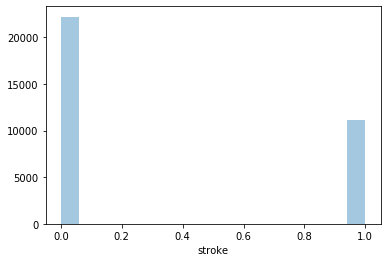

In [56]:
sns.distplot(a=y_resampled, kde=False)

In [57]:
model = XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=0, eval_metric='logloss',use_label_encoder=False)
model.fit(X_resampled, y_resampled)
preds = model.predict(X_test)
y_test.name = 'expected'
results = pd.concat([y_test, pd.Series(preds, index=y_test.index, name='got')], axis=1)


In [58]:
recessed = results[results.expected == 1]
non_recessed = results[results.expected == 0]
acc_rec = accuracy_score(recessed.expected, recessed.got)
acc_nrec = accuracy_score(non_recessed.expected, non_recessed.got)

In [59]:
acc_rec, acc_nrec

(0.15333333333333332, 0.9654397302613094)

In [60]:
#=========Trial ends

#### Modify our function to do the trial several times and average it

In [61]:
def test_with_tts3(model, data, smpl_strat='rusamp', random_state=0):
    
    X_train, X_test, y_train, y_test = train_test_split(
        data.drop('stroke', axis=1), 
        data.stroke, 
        random_state=random_state
    )
    if smpl_strat == 'rusamp':
        rus = RandomUnderSampler(sampling_strategy=0.5,random_state=0)
        X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
    elif smpl_strat == 'rosamp':
        ros = RandomOverSampler(sampling_strategy=0.5,random_state=0)
        X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    elif smpl_strat == 'smote':
        smote = SMOTE(sampling_strategy=0.5,random_state=0)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    elif smpl_strat == 'roruSamp':
        ros = RandomOverSampler(sampling_strategy=0.5,random_state=0)
        rus = RandomUnderSampler(sampling_strategy=0.6,random_state=0)
        #rfc_pipeline = Pipeline(steps = [('o', ros),('u', rus),('model', model)])
        X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train, y_train)
        X_resampled_rus, y_resampled_rus = rus.fit_resample(X_train, y_train)
        X_resampled = pd.concat([X_resampled_ros, X_resampled_rus])
        y_resampled = pd.concat([y_resampled_ros, y_resampled_rus])
    elif smpl_strat == 'ruroSamp':
        ros = RandomOverSampler(sampling_strategy=0.6,random_state=0)
        rus = RandomUnderSampler(sampling_strategy=0.5,random_state=0)
        #rfc_pipeline = Pipeline(steps = [('o', ros),('u', rus),('model', model)])
        X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train, y_train)
        X_resampled_rus, y_resampled_rus = rus.fit_resample(X_train, y_train)
        X_resampled = pd.concat([X_resampled_rus, X_resampled_ros])
        y_resampled = pd.concat([y_resampled_rus, y_resampled_ros])
    elif smpl_strat == 'smruSamp':
        smote = SMOTE(sampling_strategy=0.5,random_state=0)
        rus = RandomUnderSampler(sampling_strategy=0.6,random_state=0)
        X_resampled_sm, y_resampled_sm = smote.fit_resample(X_train, y_train)
        X_resampled_rus, y_resampled_rus = rus.fit_resample(X_train, y_train)
        X_resampled = pd.concat([X_resampled_sm, X_resampled_rus])
        y_resampled = pd.concat([y_resampled_sm, y_resampled_rus])
    elif smpl_strat == 'rusmSamp':
        smote = SMOTE(sampling_strategy=0.6,random_state=0)
        rus = RandomUnderSampler(sampling_strategy=0.5,random_state=0)
        X_resampled_sm, y_resampled_sm = smote.fit_resample(X_train, y_train)
        X_resampled_rus, y_resampled_rus = rus.fit_resample(X_train, y_train)
        X_resampled = pd.concat([X_resampled_rus, X_resampled_sm])
        y_resampled = pd.concat([y_resampled_rus, y_resampled_sm])
    X_resampled = pd.DataFrame(X_resampled, columns=X_test.columns) 
    
    
    model.fit(X_resampled, y_resampled)
    preds = model.predict(X_test)
    y_test.name = 'expected'
    results = pd.concat(
        [y_test, pd.Series(preds, index=y_test.index, name='got')], 
        axis=1
    )

    recessed = results[results.expected == 1]
    non_recessed = results[results.expected == 0]
    acc_rec = accuracy_score(recessed.expected, recessed.got)
    acc_nrec = accuracy_score(non_recessed.expected, non_recessed.got)
    
    return (acc_rec, acc_nrec)



def test_with_mc3(n_it, model, data, smpl_strat='rusamp'):
    random.seed(0)
    
    results_rec = []
    results_nrec = []
    for i in range(n_it):
        r_r, r_n = test_with_tts3(
            model, 
            data, 
            smpl_strat, 
            i*random.randint(0,1e2) # randomises train_test_split
        )
        results_rec.append(r_r)
        results_nrec.append(r_n)
    acc_rec = sum(results_rec)/len(results_rec)
    acc_nrec = sum(results_nrec)/len(results_nrec)
    return (acc_rec, acc_nrec)

In [62]:
# Since random forest performed well, lets use this

# roruSamp - overSampling & UnderSampling

rf_roruSamp3 = test_with_mc3(
    20, 
    XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=0, eval_metric='logloss',use_label_encoder=False),
    data, 
    smpl_strat='roruSamp'
)

print_acc_res(rf_roruSamp3)

Stroke classification accuracy: 0.15%
None-stroke classification accuracy: 0.96%


In [63]:
# ruroSamp - UnderSampling & overSampling

rf_ruroSamp3 = test_with_mc3(
    20, 
    XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=0, eval_metric='logloss',use_label_encoder=False),
    data, 
    smpl_strat='ruroSamp'
)

print_acc_res(rf_ruroSamp3)

Stroke classification accuracy: 0.16%
None-stroke classification accuracy: 0.96%


In [64]:
# smruSamp - smote & UnderSampling

rf_smruSamp3 = test_with_mc3(
    20, 
    XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=0, eval_metric='logloss',use_label_encoder=False),
    data, 
    smpl_strat='smruSamp'
)

print_acc_res(rf_smruSamp3)

Stroke classification accuracy: 0.06%
None-stroke classification accuracy: 0.99%


In [65]:
# rusmSamp - UnderSampling & smote

rf_rusmSamp3 = test_with_mc3(
    20, 
    XGBClassifier(n_estimators=500, learning_rate=0.05, random_state=0, eval_metric='logloss',use_label_encoder=False),
    data, 
    smpl_strat='rusmSamp'
)

print_acc_res(rf_rusmSamp3)

Stroke classification accuracy: 0.07%
None-stroke classification accuracy: 0.98%
